d:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


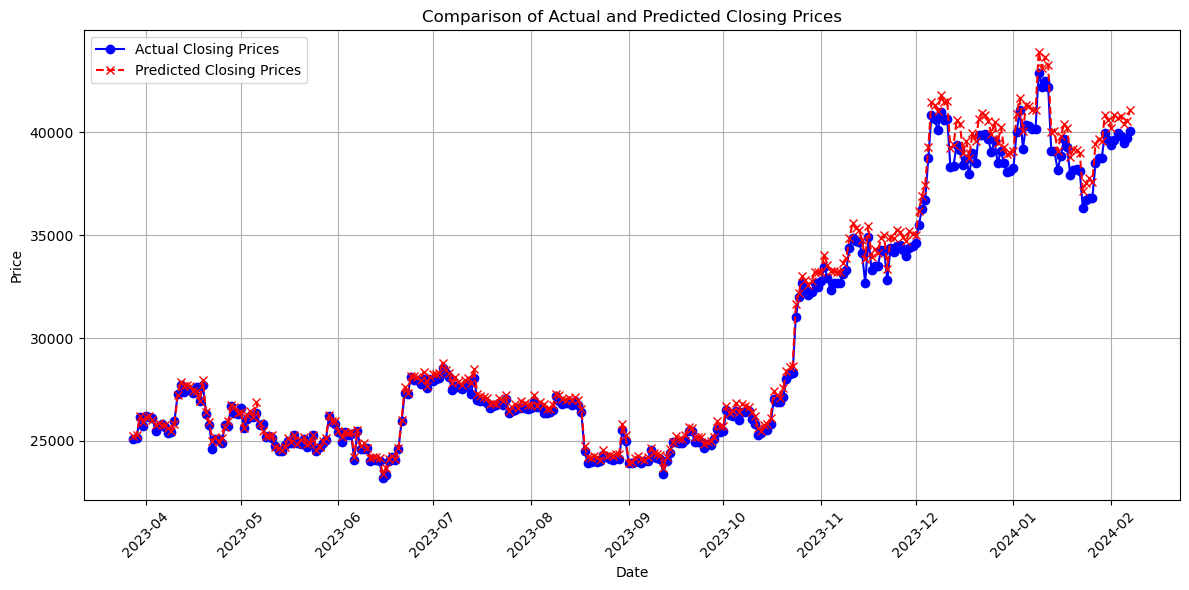

Root Mean Squared Error: 508.45048690726446
R-squared Value: 0.9920833215939678


In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the Bitcoin price data
bitcoin_data_file = 'dataset/BitcoinData.csv'
bitcoin_prices_data = pd.read_csv(bitcoin_data_file, delimiter=';')

# Change 'timeClose' to datetime format and use it as the index
bitcoin_prices_data['date'] = pd.to_datetime(bitcoin_prices_data['timeClose'])
bitcoin_prices_data.set_index('date', inplace=True)
bitcoin_prices_data.sort_index(inplace=True)  # Make sure the dates are in order

# Set data frequency to daily
bitcoin_prices_data = bitcoin_prices_data.asfreq('D')

# Choose 'close' price and other features for the model
selected_features = ['volume', 'marketCap']
close_prices = bitcoin_prices_data['close']
other_features = bitcoin_prices_data[selected_features]

# Scale the features to a range
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(other_features)
scaled_features_df = pd.DataFrame(scaled_features, columns=selected_features, index=bitcoin_prices_data.index)

# Combine the scaled features with the closing prices
combined_data = close_prices.to_frame().join(scaled_features_df)

# Add a 7-day moving average of the close prices to the dataset
combined_data['7_day_moving_average'] = combined_data['close'].rolling(window=7).mean()
combined_data.dropna(inplace=True)  # Remove rows with missing values due to moving average calculation

# Divide the dataset into training and testing parts
train_test_split_ratio = 0.8
split_point = int(len(combined_data) * train_test_split_ratio)
training_data, testing_data = combined_data.iloc[:split_point, :], combined_data.iloc[split_point:, :]

# Prepare the target and features for the model
training_target = training_data['close']
updated_features = selected_features + ['7_day_moving_average']
training_features = training_data[updated_features]

# Create and train the ARIMAX model
model = SARIMAX(training_target, exog=training_features, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Predict future values
testing_features = testing_data[updated_features]
predictions = model_fit.get_forecast(steps=len(testing_data), exog=testing_features)
predicted_values = predictions.predicted_mean

# Model performance evaluation
root_mean_squared_error = np.sqrt(mean_squared_error(testing_data['close'], predicted_values))
r_squared_value = r2_score(testing_data['close'], predicted_values)

# Visualization of actual vs predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(testing_data.index, testing_data['close'], label='Actual Closing Prices', color='blue', marker='o')
plt.plot(testing_data.index, predicted_values, label='Predicted Closing Prices', color='red', linestyle='--', marker='x')
plt.title('Comparison of Actual and Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f'Root Mean Squared Error: {root_mean_squared_error}')
print(f'R-squared Value: {r_squared_value}')
